# Importings

In [1]:
# When running in Google Colab this line is needed
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.7 MB/s eta 0:00:00


In [2]:
# Importing basic stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Train test split
from sklearn.model_selection import train_test_split

# LDA
from sklearn.decomposition import LatentDirichletAllocation

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Gridsearch
from sklearn.model_selection import GridSearchCV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Bert
from transformers import AutoTokenizer, AutoModel
# from google.colab import files

# For GPU support
import torch

# For storing models
from joblib import dump
from joblib import load


In [3]:
# For running the code with GPU, open anaconda prompt, navigate to the project folder, and type: pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html
print("CUDA available: ", torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())

CUDA available:  True
Num GPUs Available:  1


# Reading data and making it available for analysis

In [ ]:
# For creating a csv file small enough for Github
#df = pd.read_csv("./data/test.csv")
#df = df.sample(frac=0.1) # Get 10% of the data
#df.to_csv('./data/reducedDataset.csv')

In [4]:
# Naming the columns of the dataset. https://stackoverflow.com/questions/31645466/give-column-name-when-read-csv-file-pandas
colNames = ['polarity', 'title', 'text']

# Loading Dataset and assigning column names
#df = pd.read_csv("./data/test.csv", names=colNames, header=None)

# Resizing the dataset, for faster computing time. A random sample from the dataset https://stackoverflow.com/questions/40986230/reduce-dataframe-size-in-pandas
#df = df.sample(frac=0.1) # Get 10% of the data

# The reduced dataset is saved seperatly
#df.to_csv('./data/reducedDataset.csv')

# Loading Dataset and assigning column names
#df = pd.read_csv("./data/reducedDataset.csv", names=colNames, header=None)

# For loading the data from Github, especially relevant when using Google Colab. https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
url = 'https://raw.githubusercontent.com/anda19ad/AI-ML-2023-Group-project/main/data/reducedDataset.csv'

# If the dataset is already fixed, use only this line
df = pd.read_csv(url, names=colNames, header=None, na_values=['missing', 'NA', 'NaN'])


In [ ]:
# Looking on the data
(
    df
    .sample(5)
    #.dtypes
    #.info()
    #.loc[:,["polarity"]]
    #.loc[:,["title"]]
    #.loc[:,["text"]]
    #.value_counts()
    #.value_counts(normalize=True) # For seeing the count in %
    #.describe()
)

,polarity,title,text
255973.0,1,It lasted a whole week!,Unfortunately it doesn't seem to be a real Tim...
156153.0,1,Short changed on toner,Cartridge was advertised as 4000 page capacity...
279491.0,1,There are better alternatives,The double X in this stand and wide legs make ...
371258.0,2,A Wonderful Book!!,Antonia Fraser is one of my favorite authors a...
361135.0,1,Not what I expected,Many years ago when my children were small I h...


In [5]:
# Cleaning the data. Removing null values and only take the values that contain info.
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
df.dropna(how='any')
df = df[df['title'].notna()]
df = df[df['text'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 40000 entries, nan to 100360.0
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  40000 non-null  int64 
 1   title     40000 non-null  object
 2   text      40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
# Assigning values to X and Y
xText = df.text
xTitle = df.title
y = df.polarity

xText.head(1)

NaN    My lovely Pat has one of the GREAT voices of h...
Name: text, dtype: object

In [ ]:
# For an experiment the df is reduced to 4000 instances. Aligned with the "Bert" models
dfEX = df.sample(frac=0.1)
dfEX.describe()

,polarity
count,4000.00000
mean,1.49850
std,0.50006
min,1.00000
25%,1.00000
50%,1.00000
75%,2.00000
max,2.00000


In [ ]:
# Train test split of data. Putting O at the end of the X variables for "original"
X_train, X_test, y_train, y_test = train_test_split(xTitle, y, test_size=0.33, random_state=42)

In [ ]:
# Looking on one example
print("type of X_train: {}".format(type(X_train)))
print("length of X_train: {}".format(len(X_train)))
print("X_train[1]:\n{}".format(X_train.iloc[1500]))

type of X_train: <class 'pandas.core.series.Series'>
length of X_train: 26800
X_train[1]:
The CD is terrific and I have been playing it so often I may be wearing it out. The delivery was very quick, the CD is in PERFECT condition, and I thank you, so very much for offering "Frontiers" at such a reasonable price. Thank YOU again, and I look forward to purchase from you in the future.


# Topic Categorization

In [ ]:
# Configuration
# Defining the main variables to easily experiment
numberOfTopics = 20
numberOfTerms = 10
ngram = (1,2) # or (1,1)
LDAvectorizer = TfidfVectorizer #or CountVectorizer

In [ ]:
# Using CountVectorizer, as in the other models that have been built. See this guide: https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
vectLDA = LDAvectorizer(min_df=3,
                          ngram_range=ngram,
                          max_df=.01
                          #max_df=.1
                          #max_df=.15
                          )
X_trainLDA = vectLDA.fit_transform(X_train)

In [ ]:
# See page 349 in the book, and https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# Number of topics default is 10 and learning method defualt is "batch"
lda = LatentDirichletAllocation(n_components=numberOfTopics, learning_method="batch", max_iter=25, random_state=0)

# Fitting and transforming in one step
topics = lda.fit_transform(X_trainLDA)

# Printing the shape
lda.components_.shape

(20, 7866)

In [ ]:
# Get Components/topics https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html 
lda_components=lda.components_

# Printing the topics with their terms
terms = vectLDA.get_feature_names_out()

# a for loop that takes the most frequent terms in each of the topics and prints it
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:numberOfTerms]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['great product', 'worth the', 'really', 'not worth', 'the money', 'great movie', 'made', 'something', 'poorly', 'flimsy']
Topic 1:  ['disappointed', 'fantastic', 'expected', 'not what', 'hard', 'good product', 'what expected', 'very disappointed', 'avoid', 'hard to']
Topic 2:  ['boring', 'pretty', 'beautiful', 'outstanding', 'pretty good', 'rocks', 'same', 'good read', 'battery', 'looking']
Topic 3:  ['gift', 'disappointment', 'if', 'most', 'wrong', 'christmas', 'if you', 'right', 're', 'this is']
Topic 4:  ['amazing', 'dvd', 'stars', 'story', 'doesn', 'doesn work', 'cd', 'sad', 'complete', 'amazon']
Topic 5:  ['price', 'good book', 'the price', 'customer', 'brilliant', 'missing', 'super', 'service', 'fabulous', 'customer service']
Topic 6:  ['terrible', 'awful', 'do', 'do not', 'buy this', 'not good', 'don buy', 'not buy', 'worth it', 'fun']
Topic 7:  ['horrible', 'waste your', 'much', 'don waste', 'your money', 'nice', 'small', 'far', 'cool', 'voice']
Topic 8:  ['disappoin

# Basics - Tfidvectorizer plus logistic regression

In [ ]:
# Configuration for the basic model
# Lining up some variables to choose from. Including the vectorizer
vectorizerForBasic = TfidfVectorizer # or CountVectorizer
ngramForBasic = (1,1) # or (1,2). Default is (1,1)
max_dfBasic = 0.01

In [ ]:
# Applying Count vectorizer. Testing different max_df to get an understanding of the data
vect = vectorizerForBasic(min_df=3,
                          ngram_range = ngramForBasic,
                          max_df=max_dfBasic
                       )
vect.fit(X_train)
X_trainB = vect.transform(X_train)
X_testB = vect.transform(X_test)


In [ ]:
# Looking on the vectorized features. See page 331 for code
feature_names = vect.get_feature_names_out() # under methods: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 10010 to 10030:\n{}".format(feature_names[10010:10030]))
print("Every 1000th feature:\n{}".format(feature_names[::1000]))

Number of features: 577
First 20 features:
['10' '100' '12' '1st' '2001' 'about' 'absolute' 'absolutely' 'acting'
 'after' 'again' 'air' 'album' 'albums' 'almost' 'already' 'also' 'always'
 'am' 'amazing']
Features 10010 to 10030:
[]
Every 1000th feature:
['10']


In [ ]:
# Making a logistic regression model
BaseLR = LogisticRegression(max_iter=10000)

# Fitting the model
BaseLR.fit(X_trainB, y_train)

# Printing results
print("Accuracy on training set: {:.3f}".format(BaseLR.score(X_trainB, y_train)))
print("Accuracy on test set: {:.3f}".format(BaseLR.score(X_testB, y_test)))
#print("Best params: ", BaseLR.best_params_) # Printing the best params

Accuracy on training set: 0.763
Accuracy on test set: 0.670


In [ ]:
# Evaluating results
y_pred = BaseLR.predict(X_testB)

# Printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.53      0.61       636
           2       0.65      0.80      0.71       684

    accuracy                           0.67      1320
   macro avg       0.68      0.66      0.66      1320
weighted avg       0.68      0.67      0.66      1320



In [ ]:
# Confusion matrix
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[339 297]
 [139 545]]


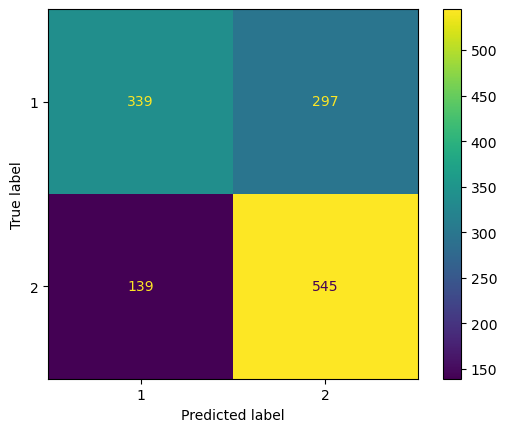

In [ ]:
# Displaying confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=BaseLR.classes_)
disp.plot()
plt.show()

In [ ]:
# Printing the features, starting with the most common. https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
n = 10 # or None to print all

sum_words = X_trainB.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:n]
#print("First 20 features:\n{}".format(words_freq[:20]))

[('disappointing', 23.456981280368545),
 ('so', 18.462102018743803),
 ('price', 18.448796801583814),
 ('works', 17.031097048822623),
 ('little', 16.684675959770217),
 ('worst', 16.680464904690684),
 ('wonderful', 16.07231251598828),
 ('by', 15.884921100716706),
 ('too', 15.633004900072953),
 ('awesome', 15.52549119525421)]

# Sentiment analysis

In [ ]:
# Printing function to be used at the end of each run through of a model. Name is a string, and should refer to the model. Search refers to the Gridsearch model.
def printScoreParams(name, search):
    y_pred = search.predict(X_test)
    print("The results from: " + name)
    print("Accuracy on training set: {:.3f}".format(search.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(search.score(X_test, y_test)))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("\n AUC-ROC: ", roc_auc_score(y_test, y_pred))
    print("Best params: ", search.best_params_) # Printing the best params

## TfidVectorizer

Starting with making models using TfidVectorizer

### Configuration

In [ ]:
# Predefined Standard variables for the pipeline and Gridsearch. To make the preprocessing with the vectorizer standard on all models. 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer() # Alternatively one could apply Countvectorizer and then TfidTransformer afterwards
ngram_range = [(1,1),(1,2)]
use_idf = [True,False]
min_df = [3]
max_df = [.01, .1, .2] # 1%, 10% or 20%

### Logistic Regression

In [ ]:
# Pipeline for Logistic Regression
pipeLR = Pipeline(steps=[
    ('Vectorizer', vectorizer),
    ('Model', LogisticRegression(max_iter=10000))
])

# Fitting the pipeline with data
pipeLR.fit(X_train, y_train)

Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                ('Model', LogisticRegression(max_iter=10000))])

In [ ]:
# Printing scores
print("Accuracy on training set: {:.3f}".format(pipeLR.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeLR.score(X_test, y_test)))

Accuracy on training set: 0.907
Accuracy on test set: 0.855


In [ ]:
# Pipeline together with gridsearchCV: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# Defining parameters for the param grid
params = {
    'Vectorizer__ngram_range':ngram_range,
    'Vectorizer__min_df':min_df,
    'Vectorizer__max_df':max_df,
    'Vectorizer__use_idf':use_idf,
    'Model__C':[0.01, 0.1, 1, 10, 100]
}

# Defining grid search
searchLR = GridSearchCV(
    pipeLR,
    #verbose = 1.5, # To track the progress
    param_grid=params,
    cv=2,
)

# Fitting the grid search
searchLR.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                                       ('Model',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Vectorizer__max_df': [0.01, 0.1, 0.2],
                         'Vectorizer__min_df': [3],
                         'Vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Vectorizer__use_idf': [True, False]})

In [ ]:
# Using the print function
printScoreParams('"B" Logistic Regression', searchLR)

The results from: "B" Logistic Regression
Accuracy on training set: 0.998
Accuracy on test set: 0.880
Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.88      0.88      6607
           2       0.88      0.88      0.88      6593

    accuracy                           0.88     13200
   macro avg       0.88      0.88      0.88     13200
weighted avg       0.88      0.88      0.88     13200

Confusion Matrix: 
 [[5813  794]
 [ 794 5799]]

 AUC-ROC:  0.8796968343697174
Best params:  {'Model__C': 10, 'Vectorizer__max_df': 0.2, 'Vectorizer__min_df': 3, 'Vectorizer__ngram_range': (1, 2), 'Vectorizer__use_idf': True}


### MLP

In [ ]:
# Defining pipe for MLP
pipeMLP = Pipeline(steps=[
    ('Vectorizer', vectorizer),
    ('Model', MLPClassifier(max_iter=10000))
])

# Fitting the pipeline with the data
pipeMLP.fit(X_train, y_train)

Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                ('Model', MLPClassifier(max_iter=10000))])

In [ ]:
# Printing scores on the simple version of the model
print("Accuracy on training set: {:.3f}".format(pipeMLP.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeMLP.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.827


In [ ]:
# Defining parameters for the param grid. Very intensive when it comes to computing time. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
params = {
    'Vectorizer__ngram_range':ngram_range,
    'Vectorizer__min_df':min_df,
    'Vectorizer__max_df':max_df,
    'Vectorizer__use_idf':use_idf,
    'Model__activation':['tanh','relu'],
    'Model__hidden_layer_sizes':[50,100],
}

# Defining grid search with the pipeline
searchMLP = GridSearchCV(
    pipeMLP,
    param_grid=params,
    cv=2,
    verbose = 1.5
)

# Fitting the grid search
searchMLP.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END Model__activation=tanh, Model__hidden_layer_sizes=50, Vectorizer__max_df=0.01, Vectorizer__min_df=3, Vectorizer__ngram_range=(1, 1), Vectorizer__use_idf=True; total time= 2.0min
[CV] END Model__activation=tanh, Model__hidden_layer_sizes=50, Vectorizer__max_df=0.01, Vectorizer__min_df=3, Vectorizer__ngram_range=(1, 1), Vectorizer__use_idf=True; total time= 1.7min
[CV] END Model__activation=tanh, Model__hidden_layer_sizes=50, Vectorizer__max_df=0.01, Vectorizer__min_df=3, Vectorizer__ngram_range=(1, 1), Vectorizer__use_idf=False; total time= 2.5min
[CV] END Model__activation=tanh, Model__hidden_layer_sizes=50, Vectorizer__max_df=0.01, Vectorizer__min_df=3, Vectorizer__ngram_range=(1, 1), Vectorizer__use_idf=False; total time= 1.8min
[CV] END Model__activation=tanh, Model__hidden_layer_sizes=50, Vectorizer__max_df=0.01, Vectorizer__min_df=3, Vectorizer__ngram_range=(1, 2), Vectorizer__use_idf=True; total time= 3.7min
[C

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                                       ('Model',
                                        MLPClassifier(max_iter=10000))]),
             param_grid={'Model__activation': ['tanh', 'relu'],
                         'Model__hidden_layer_sizes': [50, 100],
                         'Vectorizer__max_df': [0.01, 0.1, 0.2],
                         'Vectorizer__min_df': [3],
                         'Vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Vectorizer__use_idf': [True, False]},
             verbose=1.5)

In [ ]:
# Printing the results
printScoreParams('MLP', searchMLP)

The results from: MLP
Accuracy on training set: 1.000
Accuracy on test set: 0.874
Classification Report: 
               precision    recall  f1-score   support

           1       0.87      0.87      0.87      6607
           2       0.87      0.87      0.87      6593

    accuracy                           0.87     13200
   macro avg       0.87      0.87      0.87     13200
weighted avg       0.87      0.87      0.87     13200

Confusion Matrix: 
 [[5772  835]
 [ 828 5765]]

 AUC-ROC:  0.8740155722397392
Best params:  {'Model__activation': 'tanh', 'Model__hidden_layer_sizes': 50, 'Vectorizer__max_df': 0.2, 'Vectorizer__min_df': 3, 'Vectorizer__ngram_range': (1, 2), 'Vectorizer__use_idf': False}


In [ ]:
#
# BE careful before running this code! Make sure you dont overwrite a previous model!
#
# Joblip is loaded as "dump" https://www.projectpro.io/recipes/save-trained-model-in-python
# Saving the model
dump(searchMLP, 'ML_Models/mlp_model_insertText.joblib') 

# Downloading the file. Relevant in Google Colab
#files.download('mlp_model_40K.joblib')

['ML_Models/mlp_model_40K_Text.joblib']

In [ ]:
# Load the model with joblip
#searchMLP = load('ML_Models/mlp_model_40K_Title.joblib') 
#searchMLP = load('ML_Models/mlp_model_4K_Title.joblib') 
searchMLP = load('ML_Models/mlp_model_40K_Text.joblib') 

In [ ]:
# Printing the results
printScoreParams('MLP', searchMLP)

The results from: MLP
Accuracy on training set: 1.000
Accuracy on test set: 0.874
Classification Report: 
               precision    recall  f1-score   support

           1       0.87      0.87      0.87      6607
           2       0.87      0.87      0.87      6593

    accuracy                           0.87     13200
   macro avg       0.87      0.87      0.87     13200
weighted avg       0.87      0.87      0.87     13200

Confusion Matrix: 
 [[5772  835]
 [ 828 5765]]

 AUC-ROC:  0.8740155722397392
Best params:  {'Model__activation': 'tanh', 'Model__hidden_layer_sizes': 50, 'Vectorizer__max_df': 0.2, 'Vectorizer__min_df': 3, 'Vectorizer__ngram_range': (1, 2), 'Vectorizer__use_idf': False}


### Naive Bayes

In [ ]:
# Defining pipe for Naive Bayes
pipeNB = Pipeline(steps=[
    ('Vectorizer', vectorizer),
    ('Model', MultinomialNB())
])

# Fitting the pipeline with the data
pipeNB.fit(X_train, y_train)

Pipeline(steps=[('Vectorizer', TfidfVectorizer()), ('Model', MultinomialNB())])

In [ ]:
# Printing scores on the simple version of the model
print("Accuracy on training set: {:.3f}".format(pipeNB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeNB.score(X_test, y_test)))

Accuracy on training set: 0.896
Accuracy on test set: 0.815


In [ ]:
# Defining parameters for the param grid. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
params = {
    'Vectorizer__ngram_range':ngram_range,
    'Vectorizer__min_df':min_df,
    'Vectorizer__max_df':max_df,
    'Vectorizer__use_idf':use_idf,
    'Model__fit_prior':[True,False]
}

# Defining grid search with the pipeline
searchNB = GridSearchCV(
    pipeNB,
    param_grid=params,
    cv=2
)

# Fitting the grid search
searchNB.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                                       ('Model', MultinomialNB())]),
             param_grid={'Model__fit_prior': [True, False],
                         'Vectorizer__max_df': [0.01, 0.1, 0.2],
                         'Vectorizer__min_df': [3],
                         'Vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Vectorizer__use_idf': [True, False]})

In [ ]:
# Printing
printScoreParams('"D" Naive Bayes', searchNB)

The results from: "D" Naive Bayes
Accuracy on training set: 0.936
Accuracy on test set: 0.864
Classification Report: 
               precision    recall  f1-score   support

           1       0.85      0.88      0.87      6607
           2       0.88      0.85      0.86      6593

    accuracy                           0.86     13200
   macro avg       0.86      0.86      0.86     13200
weighted avg       0.86      0.86      0.86     13200

Confusion Matrix: 
 [[5823  784]
 [1007 5586]]

 AUC-ROC:  0.8643001113568746
Best params:  {'Model__fit_prior': True, 'Vectorizer__max_df': 0.1, 'Vectorizer__min_df': 3, 'Vectorizer__ngram_range': (1, 2), 'Vectorizer__use_idf': True}


### Random Forrest

In [ ]:
# Defining pipe for Random Forrest
pipeRF = Pipeline(steps=[
    ('Vectorizer', vectorizer),
    ('Model', RandomForestClassifier())
])

# Fitting the pipeline with the data
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                ('Model', RandomForestClassifier())])

In [ ]:
# Printing scores on the simple version of the model
print("Accuracy on training set: {:.3f}".format(pipeRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeRF.score(X_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.798


In [ ]:
# Defining parameters for the param grid
params = {
    'Vectorizer__ngram_range':ngram_range,
    'Vectorizer__min_df':min_df,
    'Vectorizer__max_df':max_df,
    'Vectorizer__use_idf':use_idf,
    'Model__n_estimators':[50,100,150], # other parameters to be defined
    'Model__max_depth':[5,10],
    'Model__min_samples_leaf':[5,10],
    'Model__random_state':[42]
}

# Defining grid search with the pipeline
searchRF = GridSearchCV(
    pipeRF,
    param_grid=params,
    cv=2,
)

# Fitting the grid search
searchRF.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Vectorizer', TfidfVectorizer()),
                                       ('Model', RandomForestClassifier())]),
             param_grid={'Model__max_depth': [5, 10],
                         'Model__min_samples_leaf': [5, 10],
                         'Model__n_estimators': [50, 100, 150],
                         'Model__random_state': [42],
                         'Vectorizer__max_df': [0.01, 0.1, 0.2],
                         'Vectorizer__min_df': [3],
                         'Vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Vectorizer__use_idf': [True, False]})

In [ ]:
# Printing
printScoreParams('"M" Random Forest', searchRF)

The results from: "M" Random Forest
Accuracy on training set: 0.753
Accuracy on test set: 0.742
Classification Report: 
               precision    recall  f1-score   support

           1       0.83      0.61      0.70      6607
           2       0.69      0.87      0.77      6593

    accuracy                           0.74     13200
   macro avg       0.76      0.74      0.74     13200
weighted avg       0.76      0.74      0.74     13200

Confusion Matrix: 
 [[4054 2553]
 [ 857 5736]]

 AUC-ROC:  0.7418026480332818
Best params:  {'Model__max_depth': 10, 'Model__min_samples_leaf': 5, 'Model__n_estimators': 150, 'Model__random_state': 42, 'Vectorizer__max_df': 0.2, 'Vectorizer__min_df': 3, 'Vectorizer__ngram_range': (1, 1), 'Vectorizer__use_idf': False}


## BERT

Next up, we want to use Bert for preprocessing. Note that the BERT embeddings are saved as a file!

In [ ]:
# Empty the cache to free memory for calculating BERT. Only relevant when iterating through the entire BERT process in Google colab
#del bert
# torch.cuda.empty_cache()

In [7]:
# Checking status of the GPU
!nvidia-smi

Thu May 18 11:10:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Check if GPU is available and if not, fall back on CPU. Relevant when using Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration. Choosing the type of BERT model, distilbert is the "smaller" one
modelName = 'distilbert-base-uncased'

In [9]:
# Retreiving Bert
bert = AutoModel.from_pretrained(modelName)

# Move model to the device, to leverage GPU if available
bert = bert.to(device)

BertToken = AutoTokenizer.from_pretrained(modelName)
#print(bert)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Reducing data even more
dfBert = df.sample(frac=0.1)
dfBert.describe()

,polarity
count,4000.000000
mean,1.494750
std,0.500035
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [11]:
# Tokenizing
print("Tokenizing...")
tokenized = BertToken(
    dfBert["title"].tolist(),
    add_special_tokens=True,
    padding='longest',
    return_attention_mask=True,
    return_tensors='pt',
    verbose=True
)

# Move tokenized data to the device
tokenized = {k: v.to(device) for k, v in tokenized.items()}

tokenized

Tokenizing...


{'input_ids': tensor([[  101,  2025,  3407,  ...,     0,     0,     0],
         [  101,  1037,  2442,  ...,     0,     0,     0],
         [  101,  8687,  1010,  ...,     0,     0,     0],
         ...,
         [  101,  4067, 29337,  ...,     0,     0,     0],
         [  101,  2204,  2338,  ...,     0,     0,     0],
         [  101,  2064,  1005,  ...,     0,     0,     0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [12]:
# 
# Not that there embeddings are save in a seperate file also. This function is only to be used if new embeddings are required 
#
# A function that was also used in Lab 7. Note that this is a ressource intensive task
def get_bert_embeddings(model, tokenized):

    """ Calculate BERT embeddings for a batch of sentences.
    NOTE: Calculating BERT embeddings is a very expensive operation.
    Particularly on CPU, it can take a long time to calculate embeddings for
    a large batch of sentences (Max 10-20 minutes for 6K sentences).
    Args:
        model (transformers BERT model): BERT model.
        tokenized (dict): Dictionary of tokenized sentences (input_ids and attention_mask)
    Returns:
        n-d NumPy array: BERT embeddings for the sentences in the batch.
    """
    print("Getting model encodings...")
    # The following is a context-manager that disables gradient calculation.
    # Disabling gradient calculation is useful for inference, when you are 
    # sure that you will not call Tensor.backward(). It will reduce memory 
    # consumption for computations that would otherwise have requires_grad=True.
    # TLDR: calculating gradients is expensive. We don't need them for inference.
    with torch.no_grad():
        last_hidden_states = model(**tokenized)

    # last_hidden_states[0] is the last hidden state of the first token of the
    # sequence (classification token) further processed by a Linear layer and 
    # a Tanh activation function. The Linear layer weights are trained from the
    #  next sentence prediction (classification) objective during pretraining.
    # last_hidden_states[0].shape = (batch_size, hidden_size)
    print("Returning embeddings...")
    return last_hidden_states[0][:,0,:].cpu().numpy()

embeddings = get_bert_embeddings(bert, tokenized)
embeddings.shape

Getting model encodings...
Returning embeddings...


(4000, 768)

In [13]:
# Saving the embeddings in a seperate file, making it possible to do the long calculation only once
np.save('embeddings.npy', embeddings)

# Download the file to your local machine this codeblock is only useful in Google Colab https://stackoverflow.com/questions/51078996/how-can-i-download-this-model-from-colaboratory
#files.download('embeddings.npy')

In [14]:
# Here the embeddings can be loaded/reused
# Loading embeddings
embeddings = np.load('embeddings.npy')

In [15]:
# Making a new Train test split
X_trainBert, X_testBert, y_train, y_test = train_test_split(embeddings, dfBert.polarity, test_size= 0.33, random_state=42)

## Making Models with Bert

### Configuration

Preprocessing with BERT is already done. We can therefore use a function with gridsearch when going through the models

In [16]:
# A function to be used on all models
def eval_model(model, params, name):
    grid = GridSearchCV(estimator=model, # The desired model is called from the model that is to be defined
                    param_grid=params, # The object is called by the later defined variable
                    cv=2)  # Using cross validation
    grid.fit(X_trainBert, y_train) # The scaled version of the data is used to fit the model(s)
    print("The results from: " + name)
    y_pred = grid.predict(X_testBert)
    print("Accuracy on training set: {:.3f}".format(grid.score(X_trainBert, y_train)))
    print("Accuracy on test set: {:.3f}".format(grid.score(X_testBert, y_test)))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("\n AUC-ROC: ", roc_auc_score(y_test, y_pred))
    print("Best params: ", grid.best_params_) # Printing the best params
    print(" ")

    # Returning the Model for later use
    return grid

In [17]:
# Configuration of the different models, Setting up the models with relevant parameters to tune. scikit learn documentation is used for each model to find parameters.
lr_B = LogisticRegression(max_iter=10000)
lrParams = {'C':[0.01,0.1,1,10,100]} 

mlp_B = MLPClassifier(max_iter=10000)
mlpParams = {'hidden_layer_sizes':[50,100], 'activation': ['tanh','relu']}

NB_B = MultinomialNB()
NBParams = {'fit_prior':[True,False]} 

rfc_B = RandomForestClassifier()
rfcParams = {'n_estimators':[50,100,150], 'max_depth':[5,10],'min_samples_leaf':[5,10],'random_state':[42] }

### Logistic Regression

In [18]:
# Applying the model with the function
eval_model(lr_B, lrParams, 'LRBert')

The results from: LRBert
Accuracy on training set: 0.829
Accuracy on test set: 0.810
Classification Report: 
               precision    recall  f1-score   support

           1       0.82      0.81      0.81       675
           2       0.80      0.81      0.81       645

    accuracy                           0.81      1320
   macro avg       0.81      0.81      0.81      1320
weighted avg       0.81      0.81      0.81      1320

Confusion Matrix: 
 [[547 128]
 [123 522]]

 AUC-ROC:  0.8098363479758829
Best params:  {'C': 0.1}
 


GridSearchCV(cv=2, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

### MLP

In [ ]:
# Applying the model with the function
eval_model(mlp_B, mlpParams, 'MLPBert')

The results from: MLPBert
Accuracy on training set: 0.979
Accuracy on test set: 0.484
Classification Report: 
               precision    recall  f1-score   support

           1       0.48      0.39      0.43       658
           2       0.49      0.58      0.53       662

    accuracy                           0.48      1320
   macro avg       0.48      0.48      0.48      1320
weighted avg       0.48      0.48      0.48      1320

Confusion Matrix: 
 [[258 400]
 [281 381]]

 AUC-ROC:  0.4838129826720172
Best params:  {'activation': 'tanh', 'hidden_layer_sizes': 100}
 


GridSearchCV(cv=2, estimator=MLPClassifier(max_iter=10000),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [50, 100]})

### Naive Bayes

In [ ]:
# Applying the model with the function
eval_model(NB_B, NBParams, 'NBBert')

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 898, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1418, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


### Random Forest

In [ ]:
# Applying the model with the function
eval_model(rfc_B, rfcParams, 'rfcBert')

rfcBert
Accuracy on training set: 0.875
Accuracy on test set: 0.801
Best params:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100, 'random_state': 42}
 


GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [5, 10],
                         'n_estimators': [50, 100, 150], 'random_state': [42]})